In [1]:
import pandas as pd 
import numpy as np
from time import time
import seaborn as sns

In [2]:
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import preprocessing

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib import pyplot

import sys
import warnings
warnings.filterwarnings("ignore")

## Dataset

In this section we import our dataset (already processed and encoded) and check for correlated variables

The features we are interested in have to be as independent as possible from each other. Therefore, we are going to
make sure that we don't have any correlated columns with a value higher than .95

In [141]:
cor_matrix = dataset.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(); print(to_drop)  



[]


<AxesSubplot:>

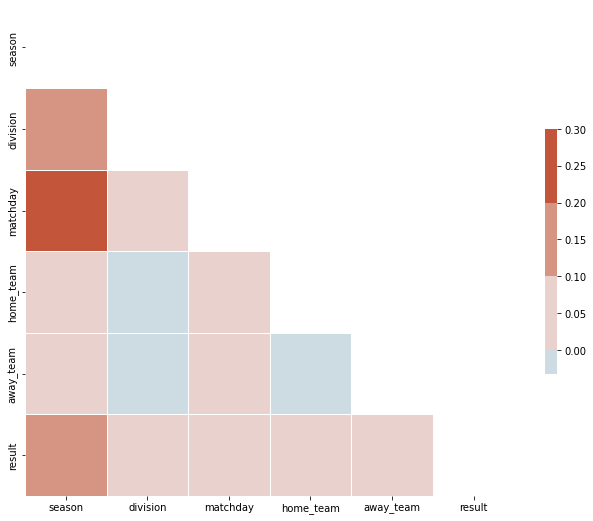

In [155]:
# Compute the correlation matrix
corr = dataset.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=False)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Automatic Variable Selection
In order to have an automatic variable selection we can use a **model-based** feature selection. Consequently, we will use a supervised machine learning model to judge the importance of each feature.

We will add some noise feature to our data and expect that the feature selection will identify the features that are non informative, removing the data features that are irrelevant.

For that purpose, we will add as many noise features as we have and select the 50% that are more correlated. Then, we will discard the noise features. The variables selected can be shown belove: black are original features and white noise features

X_train.shape: (12060, 8)
y_train.shape: (12060,)
X_train_l1.shape: (12060, 8)


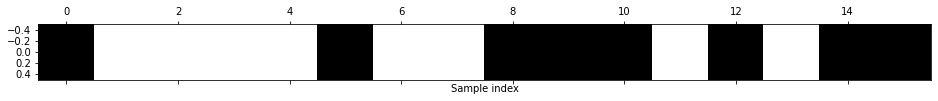

In [149]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

dataset = dataset.dropna()
target = dataset.result
X = dataset.loc[:, dataset.columns != 'result']

# get deterministic random numbers
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(dataset), 11))
X_w_noise = np.hstack([X, noise])

X_train,X_test,y_train,y_test = train_test_split(X_w_noise, target, test_size=0.75)

select = SelectFromModel( RandomForestClassifier(n_estimators=100, random_state=42), threshold="median")

select.fit(X_train, y_train)
X_train = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("y_train.shape: {}".format(y_train.shape))

print("X_train_l1.shape: {}".format(X_train.shape))

mask = select.get_support()
# visualize the mask -- black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")

X_test_l1 = select.transform(X_test)

## Normal selection of variables and splitting data

In [156]:
dataset = dataset.dropna()
target = dataset.result
X = dataset.loc[:, dataset.columns != 'result']
#X = dataset[['season','division','matchday','team','Away_team','W','GD_cum_before','rank_before']]
X_train,X_test,y_train,y_test = train_test_split(X, target, test_size=0.75)

## Function to construct confusion matrix and ROC

In [157]:
#plot our results
def confusion_matrix(trained_model, y_test, X_test):
    Y_test_pred = trained_model.predict(X_test)

    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)
    skplt.metrics.plot_confusion_matrix(y_test, Y_test_pred,
                                        title="Confusion Matrix",
                                        cmap="Oranges",
                                        ax=ax1)

    ax2 = fig.add_subplot(122)
    skplt.metrics.plot_confusion_matrix(y_test, Y_test_pred,
                                        normalize=True,
                                        title="Confusion Matrix",
                                        cmap="Purples",
                                        ax=ax2)

def ROC_PRC_matrix(trained_model, y_test, X_test):    
    y_test_probs = trained_model.predict_proba(X_test)
    
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)
    skplt.metrics.plot_roc_curve(y_test, y_test_probs,
                       title="Digits ROC Curve", figsize=(12,6), ax=ax1)
    
    ax2 = fig.add_subplot(122)
    skplt.metrics.plot_precision_recall_curve(y_test, y_test_probs,
                        title="Digits Precision-Recall Curve", figsize=(12,6), ax= ax2)

## Estimations of parameters in models

In [158]:
# Looking for best parameter for logistic regression model
for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    logreg = LogisticRegression(C=C).fit(X_train, y_train)
    prediction_in = logreg.predict(X_train)
    accuracy_r2_in = r2_score(y_train, prediction_in)
    prediction_out = logreg.predict(X_test)
    accuracy_r2_out = r2_score(y_test, prediction_out)
    print() 
    print("Logistic Regression with parameter ", C) 
    print("-" * 20)
    print("Accuracy on training set: ",logreg.score(X_train, y_train), "\tR2 training set: ", accuracy_r2_in )
    print("Accuracy on test set: ",logreg.score(X_test, y_test), "\tR2 test set: ", accuracy_r2_out )



Logistic Regression with parameter  0.001
--------------------
Accuracy on training set:  0.5287728026533997 	R2 training set:  -0.7454749110484042
Accuracy on test set:  0.5274737423991155 	R2 test set:  -0.7473475271007985

Logistic Regression with parameter  0.01
--------------------
Accuracy on training set:  0.5287728026533997 	R2 training set:  -0.7454749110484042
Accuracy on test set:  0.5274737423991155 	R2 test set:  -0.7473475271007985

Logistic Regression with parameter  0.1
--------------------
Accuracy on training set:  0.5287728026533997 	R2 training set:  -0.7454749110484042
Accuracy on test set:  0.5274737423991155 	R2 test set:  -0.7473475271007985

Logistic Regression with parameter  1
--------------------
Accuracy on training set:  0.5287728026533997 	R2 training set:  -0.7454749110484042
Accuracy on test set:  0.5274737423991155 	R2 test set:  -0.7473475271007985

Logistic Regression with parameter  10
--------------------
Accuracy on training set:  0.5287728026533

In [159]:
# Preprunning for decision tree model, avoiding overfitting
for depth in range(3,8):
    tree = DecisionTreeClassifier(max_depth=depth).fit(X_train, y_train)
    prediction_in = tree.predict(X_train)
    accuracy_r2_in = r2_score(y_train, prediction_in)
    prediction_out = tree.predict(X_test)
    accuracy_r2_out = r2_score(y_test, prediction_out)
    print() 
    print("Decision tree with depth ", depth) 
    print("-" * 20)
    print("Accuracy on training set: ",tree.score(X_train, y_train), "\tR2 training set: ", accuracy_r2_in )
    print("Accuracy on test set: ",tree.score(X_test, y_test), "\tR2 test set: ", accuracy_r2_out )



Decision tree with depth  3
--------------------
Accuracy on training set:  0.5287728026533997 	R2 training set:  -0.7454749110484042
Accuracy on test set:  0.5274737423991155 	R2 test set:  -0.7473475271007985

Decision tree with depth  4
--------------------
Accuracy on training set:  0.5291044776119403 	R2 training set:  -0.725845867931078
Accuracy on test set:  0.5248479823106689 	R2 test set:  -0.7331420842128571

Decision tree with depth  5
--------------------
Accuracy on training set:  0.5336650082918739 	R2 training set:  -0.7079590475756445
Accuracy on test set:  0.5228026533996684 	R2 test set:  -0.7470353195647996

Decision tree with depth  6
--------------------
Accuracy on training set:  0.5375621890547264 	R2 training set:  -0.6774120751504562
Accuracy on test set:  0.5196517412935323 	R2 test set:  -0.7394252608748311

Decision tree with depth  7
--------------------
Accuracy on training set:  0.5451907131011609 	R2 training set:  -0.6573184392966251
Accuracy on test s

In [161]:
# Random forest model

# We set max_depth = 5 as preprunning parameter
# We set max_features as sqrt of n_features to reduce overfitting (pag 102)

for trees in range(5,10):
    for depth in range(2,6):
        random_forest = RandomForestClassifier(max_depth=depth, n_estimators=trees, max_features=3).fit(X_train, y_train)
        prediction_in = random_forest.predict(X_train)
        accuracy_r2_in = r2_score(y_train, prediction_in)
        prediction_out = random_forest.predict(X_test)
        accuracy_r2_out = r2_score(y_test, prediction_out)
        print() 
        print(f"Random_forest with {trees} trees and {depth} depth") 
        print("-" * 40)
        print("Accuracy on training set: ",random_forest.score(X_train, y_train), "\tR2 training set: ", accuracy_r2_in )
        print("Accuracy on test set: ",random_forest.score(X_test, y_test), "\tR2 test set: ", accuracy_r2_out )



Random_forest with 5 trees and 2 depth
----------------------------------------
Accuracy on training set:  0.5287728026533997 	R2 training set:  -0.7454749110484042
Accuracy on test set:  0.5274737423991155 	R2 test set:  -0.7473475271007985

Random_forest with 5 trees and 3 depth
----------------------------------------
Accuracy on training set:  0.5287728026533997 	R2 training set:  -0.7454749110484042
Accuracy on test set:  0.5274737423991155 	R2 test set:  -0.7473475271007985

Random_forest with 5 trees and 4 depth
----------------------------------------
Accuracy on training set:  0.5329187396351576 	R2 training set:  -0.724684386089816
Accuracy on test set:  0.5289662797125484 	R2 test set:  -0.7364592892828432

Random_forest with 5 trees and 5 depth
----------------------------------------
Accuracy on training set:  0.5343283582089552 	R2 training set:  -0.711908085835935
Accuracy on test set:  0.5303482587064676 	R2 test set:  -0.725844233058887

Random_forest with 6 trees and


Logistic Regression
--------------------
Accuracy on training set:  0.5287728026533997 	R2 training set:  -0.7454749110484042
Accuracy on test set:  0.5274737423991155 	R2 test set:  -0.7473475271007985

Decision Tree
--------------------
Accuracy on training set:  0.5287728026533997 	R2 training set:  -0.7454749110484042
Accuracy on test set:  0.5274737423991155 	R2 test set:  -0.7473475271007985

Random Forest
--------------------
Accuracy on training set:  0.5330016583747927 	R2 training set:  -0.7336277962675328
Accuracy on test set:  0.5287451630735213 	R2 test set:  -0.73969844246883


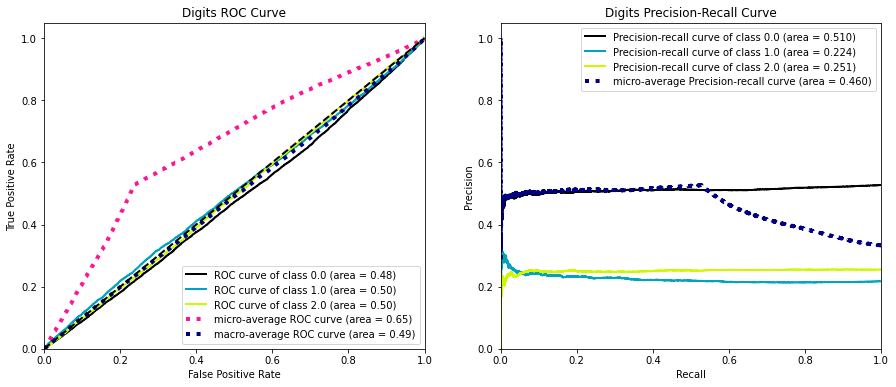

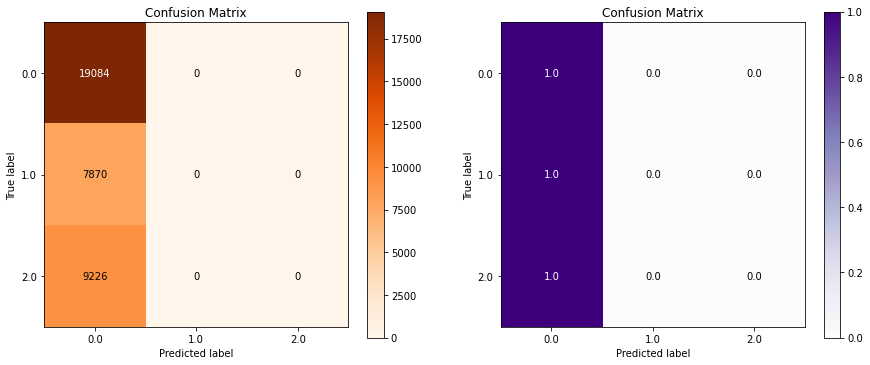

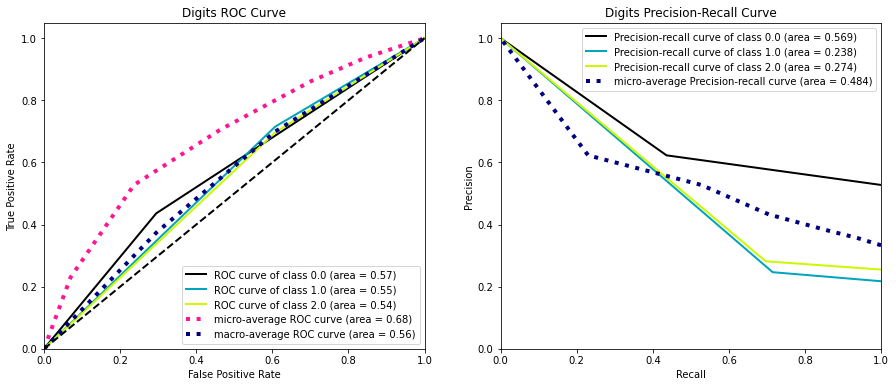

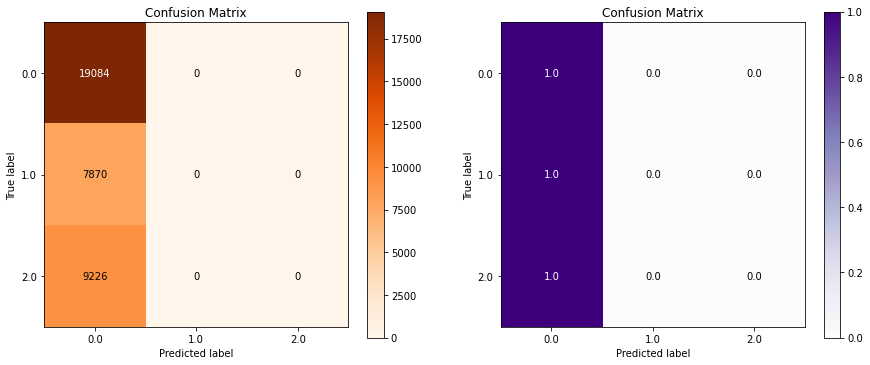

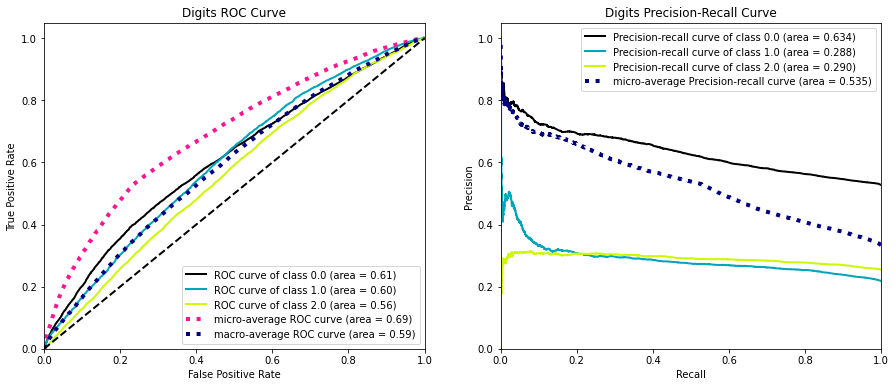

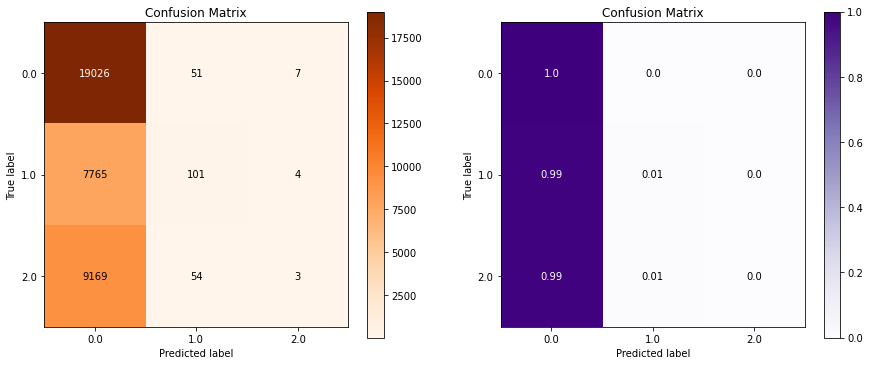

In [163]:
names = ["Logistic Regression", "Decision Tree", "Random Forest"]
         
classifiers = [
    #KNeighborsClassifier(3),
    LogisticRegression(),
    DecisionTreeClassifier(max_depth=1),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
]


for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        prediction_in = clf.predict(X_train)
        accuracy_r2_in = r2_score(y_train, prediction_in)
        prediction_out = clf.predict(X_test)
        accuracy_r2_out = r2_score(y_test, prediction_out)
        print() 
        print(name) 
        print("-" * 20)
        print("Accuracy on training set: ",clf.score(X_train, y_train), "\tR2 training set: ", accuracy_r2_in )
        print("Accuracy on test set: ",clf.score(X_test, y_test), "\tR2 test set: ", accuracy_r2_out )
        ROC_PRC_matrix(clf, y_test, X_test)
        confusion_matrix(clf, y_test, X_test)
